In [26]:
from init_nb import init_notebook
config = init_notebook()

import pandas as pd
from pathlib import Path
import numpy.linalg as npl
import matplotlib.pyplot as plt
from nilearn import plotting
import numpy as np


from bold_dementia.data.synthetic import generate_topology, generate_correlations, generate_topology_net_interaction

from bold_dementia.connectivity import Atlas, fast_hist
from bold_dementia.utils.iterables import unique

EXPORT:bool = True
DEBUG_DISP:bool = False
N_CONTROLS = 2009
N_AD = 83

ATLAS = "schaeffer200"
SOFT = False
ALPHA = config["alpha"]
atlas = Atlas.from_name(ATLAS, soft=SOFT)
labels = tuple(sorted(unique(atlas.macro_labels)))

In [27]:
topology = generate_topology("Default", atlas.macro_labels)
topology += generate_topology("SomMot", atlas.macro_labels)
topology += generate_topology_net_interaction(
    ("SomMot", "Vis"), atlas.macro_labels
)


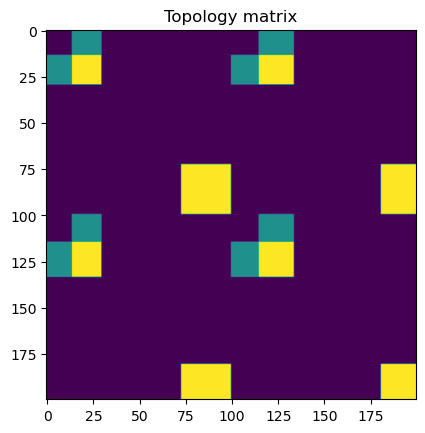

In [28]:
plt.imshow(topology)
plt.title("Topology matrix")
plt.show()

In [29]:
control_cov = np.stack(generate_correlations(N_CONTROLS, topology, 0.7, 0.1, snr=1., debug_display=DEBUG_DISP))
AD_cov = np.stack(generate_correlations(N_AD, topology, -0.5, 0.1, snr=1., debug_display=DEBUG_DISP))

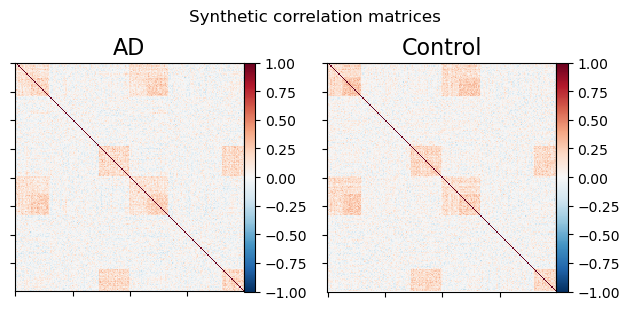

In [30]:
fig, axes = plt.subplots(1, 2)
plotting.plot_matrix(AD_cov[0], axes=axes[0], title="AD", vmin=-1)
plotting.plot_matrix(control_cov[0], axes=axes[1], title="Control", vmin=-1)
fig.suptitle("Synthetic correlation matrices", y=0.85)
plt.show()

In [31]:
control_prec = npl.inv(control_cov)
AD_prec = npl.inv(AD_cov)

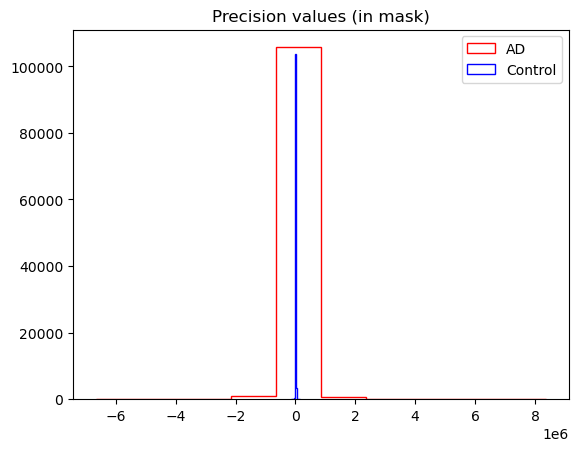

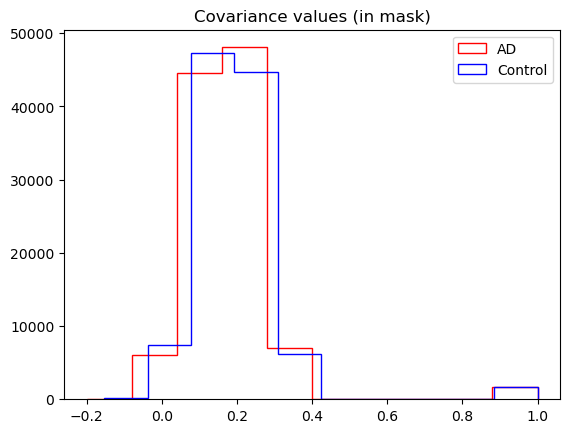

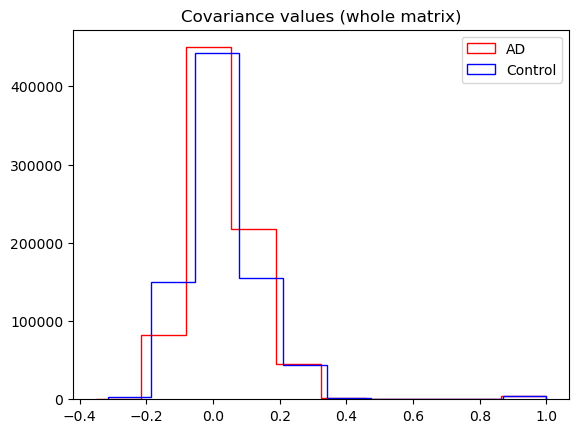

In [32]:
mask = topology > 0
fig, ax = plt.subplots()

ax.hist(
    AD_prec[:20, mask].ravel(),
    histtype="step", color="red", label="AD"
)

ax.hist(
    control_prec[:20, mask].ravel(),
    color="blue", histtype="step", label="Control"
)
plt.legend()
plt.title("Precision values (in mask)")
plt.show()

fig, ax = plt.subplots()
ax.hist(
    AD_cov[:20, mask].ravel(),
    histtype="step", color="red", label="AD"
)
ax.hist(
    control_cov[:20, mask].ravel(),
    color="blue", histtype="step", label="Control"
)
plt.legend()
plt.title("Covariance values (in mask)")
plt.show()

fig, ax = plt.subplots()
ax.hist(
    AD_cov[:20].ravel(),
    histtype="step", color="red", label="AD"
)
ax.hist(
    control_cov[:20].ravel(),
    color="blue", histtype="step", label="Control"
)
plt.legend()
plt.title("Covariance values (whole matrix)")
plt.show()

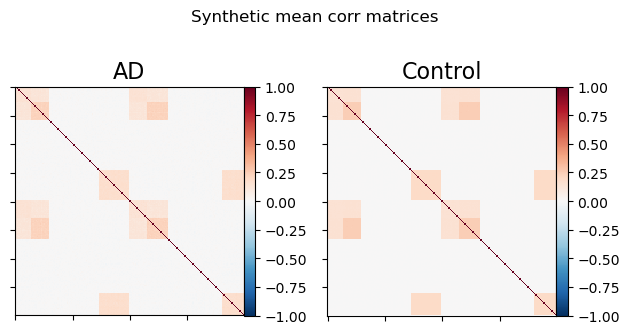

In [33]:
fig, ax = plt.subplots(1, 2)
ADm = np.mean(AD_cov, axis=0)
plotting.plot_matrix(ADm, axes=ax[0], title="AD", vmin=-1)
plotting.plot_matrix(np.mean(control_cov, axis=0), axes=ax[1], vmin=-1, title="Control")
fig.suptitle(f"Synthetic mean corr matrices", y=0.9)
plt.show()

In [34]:
import joblib
if EXPORT is True:
    export_path = Path("/bigdata/jlegrand/data/Memento/output/connectivity/atlas-schaeffer200_synthetic")
    joblib.dump(
        control_cov,
        export_path / "control.joblib"
    )
    joblib.dump(
        AD_cov,
        export_path / "AD.joblib"
    )

In [35]:
from scipy.stats import ttest_ind

tstats, pvalues = ttest_ind(
    AD_cov, control_cov, equal_var=True
)

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


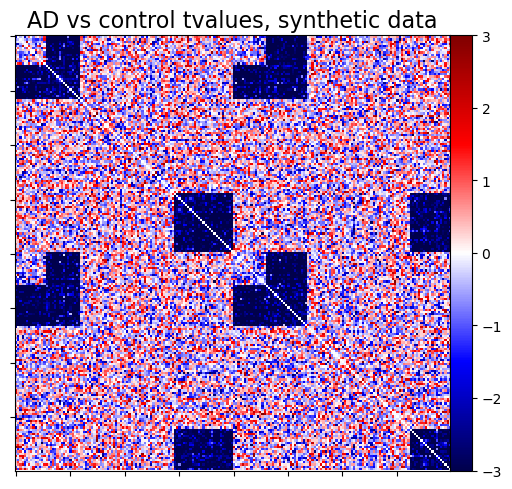

In [36]:
plotting.plot_matrix(
    tstats, cmap="seismic", vmin=-3, vmax=3, title="AD vs control tvalues, synthetic data"
)
plt.show()

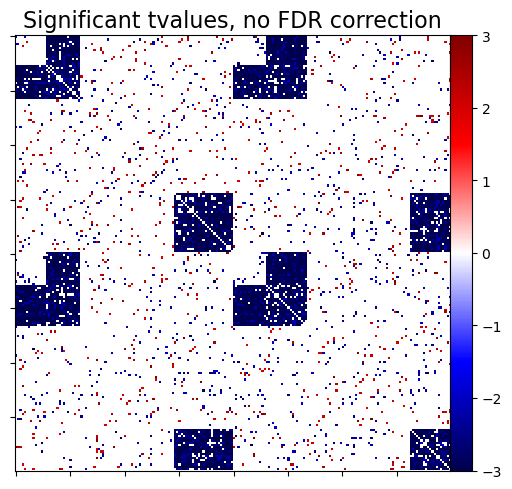

In [37]:
significant_tstats = np.where(pvalues < config["alpha"], tstats, np.nan)
plotting.plot_matrix(
    significant_tstats, cmap="seismic", vmin=-3, vmax=3, title="Significant tvalues, no FDR correction"
)
plt.show()

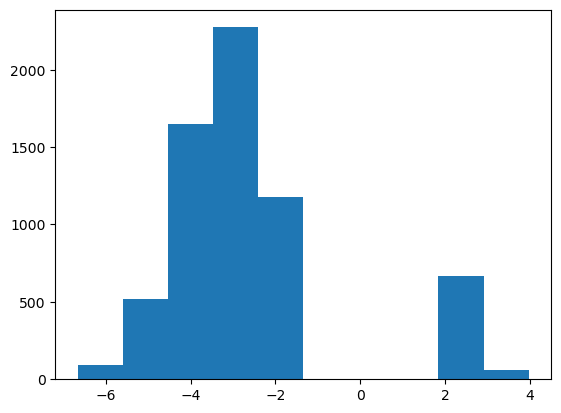

In [38]:
plt.hist(significant_tstats.flatten())
plt.show()